<a href="https://colab.research.google.com/github/Luffeboy/Colabstuff/blob/main/Unsupervised_learning_clustering_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Unsupervised Learning & Clustering

### Introduction

The purpose af this assignment is to explore Scikit-Learns facilities on unsupervised learning and clustering.

Assume that you have been hired in as a data scientist for your client, which is a major mall in your area. They want assistance to segment their customers on basis on some data they have collected. The data has the following attributes:
CustomerID: Customers ID in the malls database

*   CustomerID: Customers ID in the malls database
*   Gender: Customers gender
*   Age: Customers age
*   Annual income: Customers annual $-income in thousands
*   Spending score: A measure 1-100 on how willing the customer is to spend money

The dataset can be found here: https://raw.githubusercontent.com/jpandersen61/Machine-Learning/refs/heads/main/Mall_Customers.csv

which was originally downloaded from https://www.kaggle.com/shwetabh123/mall-customers






# Setup

###Step 1: Setup actions

In [1]:
#Import common Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN


In [3]:
 # Routines for plot_decision_boundaries lets us plot Voronoi diagram with model's decision boundaries
 # Originally defined in https://github.com/ageron/handson-ml3 chapter 9 code repository

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [4]:
# Routine for plotting DBSCAN related clusters
# Originally defined in https://github.com/ageron/handson-ml3 chapter 9 code repository

def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]

    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20,
                c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1],
                c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(f"eps={dbscan.eps:.2f}, min_samples={dbscan.min_samples}")
    plt.grid()
    plt.gca().set_axisbelow(True)



In [5]:
#Load the data for 'Mall Customers' from the 'Colab Notebooks' on your Google drive
datafile="https://raw.githubusercontent.com/jpandersen61/Machine-Learning/refs/heads/main/Mall_Customers.csv"
dataset = pd.read_csv(datafile)
dataset

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


#Find customer segments on income and spending

###Step 2: Extract and inspect the dataset

Exercises:
1. Observe how ‘annual income’ and ‘spending score’ are extracted into an array (numpy.ndarray) with 2 columns for each of them.
2. Inspect code below for plotting this income-spending dataset.
3. Do you spot any clusters by inspecting the diagram and how many?

In [6]:
X = dataset[["Annual Income (k$)", "Spending Score (1-100)"]].values


In [7]:
type(X)

numpy.ndarray

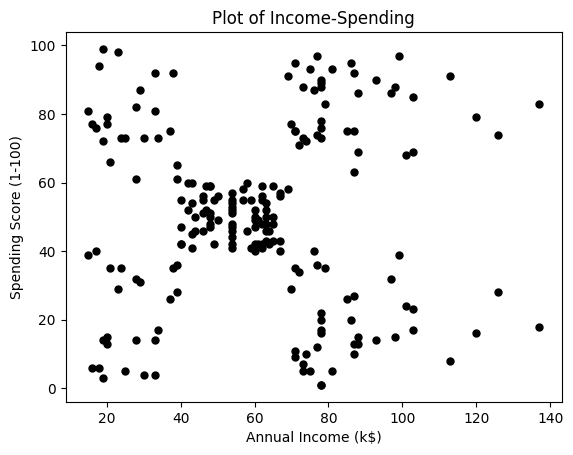

In [8]:
plt.scatter(X[:, 0], X[:, 1], s = 25, c = 'black')
plt.title('Plot of Income-Spending')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()


###Step 3: Calculate results for elbow and silhouette analysis

Exercises:
1. Perform KMeans.fit(..) on the income-spending dataset over a range from 1 to 10 clusters (as done in the code below). Compare with documentation on KMeans: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
2. Keep the inertias for each number of clusters in a list (as done in the code below).
3. Keep the silhouette scores (silhouette_score) for number of clusters in a list (as done in the code below)..

In [9]:
kmeans_per_k = [KMeans(n_init=10, n_clusters=k, init = 'k-means++', random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]


###Step 4: Determine number of clusters from inertia

Exercises:
1. Plot the inertia curve – inertia vs. number of clusters (as done in the code below).
2. Analyse the curve:
*   How many clusters does it suggest?
*   Explain the concepts of ‘underfit’ and ‘overfit’ in this context
3. What customer segmentation (number clusters) would you suggest to your client?

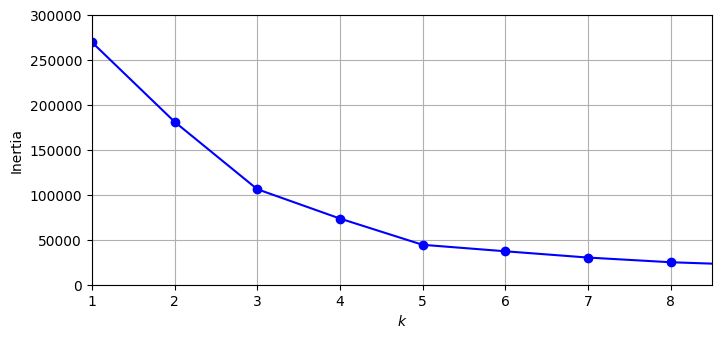

In [10]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.axis([1, 8.5, 0, 300000])
plt.grid()
plt.show()

###Step 5: Determine number of clusters from silhouette scores

Exercises:
1. Plot the clusters – assign a color to each instance according to its’ cluster label (1, 2, 3, ….) (as done in the code below).
2. Analyse the curve: How many clusters does this suggest?


    

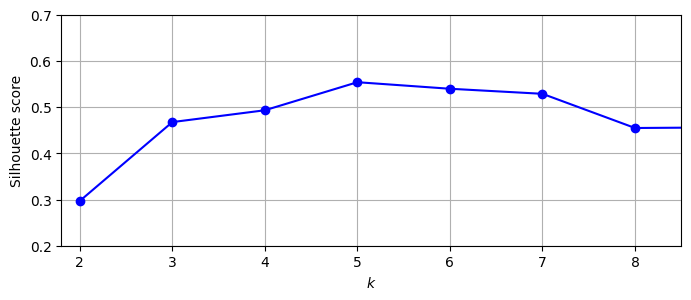

In [11]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.axis([1.8, 8.5, 0.2, 0.7])
plt.grid()
plt.show()

###Step 6: Visualize and interpret the clusters

Exercises:
1.   Use the `KMeans` algorithm to `fit` a model 5 clusters. That is `n_clusters=5` (as done the code below)?
2.   Plot the clusters – assign a color to each instance according to the calculated model parameters (as done the code below).
3. Interpret and the clusters in by characterising each. You may then assign meaningful name labels - that is the customer segment names -  to the clusters.

In [12]:
kmeans = KMeans(n_init=10, n_clusters=5, random_state=42).fit(X)

In [13]:
kmeans.cluster_centers_

array([[55.2962963 , 49.51851852],
       [86.53846154, 82.12820513],
       [25.72727273, 79.36363636],
       [88.2       , 17.11428571],
       [26.30434783, 20.91304348]])

In [14]:
kmeans.inertia_

44448.45544793369

In [15]:
silhouette_score(X, kmeans.labels_)

np.float64(0.553931997444648)

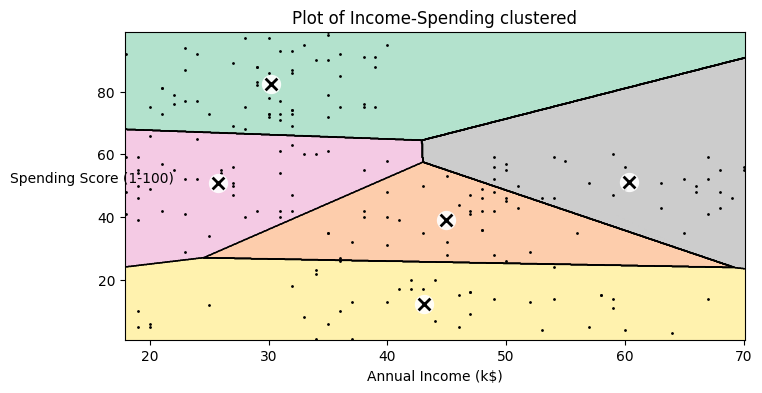

In [29]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.title('Plot of Income-Spending clustered')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

#Find customer segments on age and spending

###Step 7: Extract and inspect another dataset (age-spending score)

Execises:
1. Extract ‘age’ and ‘spending score’ in an array (`numpy.ndarray`) with 2 columns for each of
them.
2. Plot this income-spending dataset.

Notice: This is very similar to Step 2

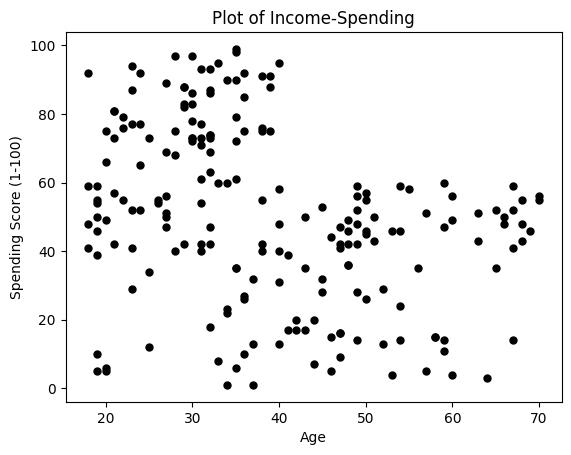

In [23]:
X = dataset[["Age", "Spending Score (1-100)"]].values
plt.scatter(X[:, 0], X[:, 1], s = 25, c = 'black')
plt.title('Plot of Income-Spending')
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.show()


###Step 8: Repeat steps 3-6 on the other dataset

Exercise:
1.   To be done on the "age-spending score" dataset extracted in step 7




In [24]:
kmeans_per_k = [KMeans(n_init=10, n_clusters=k, init = 'k-means++', random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]


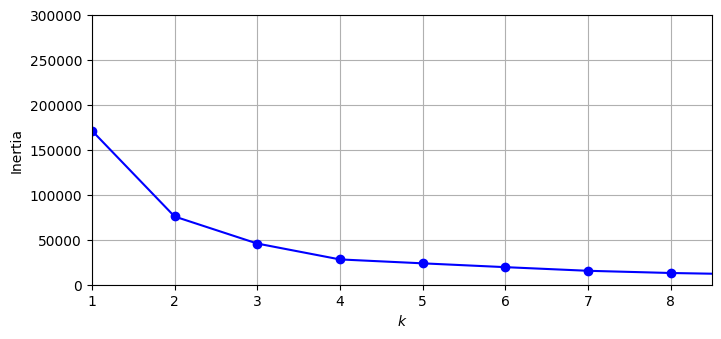

In [25]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.axis([1, 8.5, 0, 300000])
plt.grid()
plt.show()

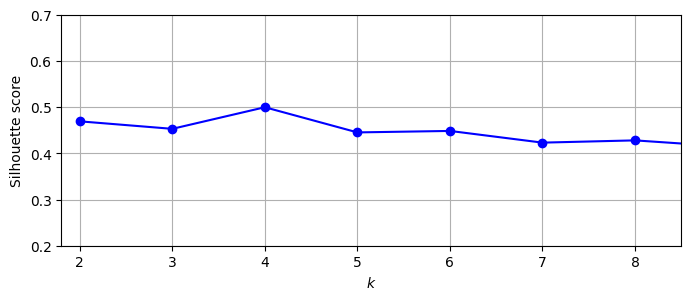

In [26]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.axis([1.8, 8.5, 0.2, 0.7])
plt.grid()
plt.show()

In [38]:
kmeans = KMeans(n_init=10, n_clusters=4, random_state=42).fit(X)
kmeans.cluster_centers_

array([[55.70833333, 48.22916667],
       [30.1754386 , 82.35087719],
       [43.29166667, 15.02083333],
       [27.61702128, 49.14893617]])

In [39]:
kmeans.inertia_

28165.583566629342

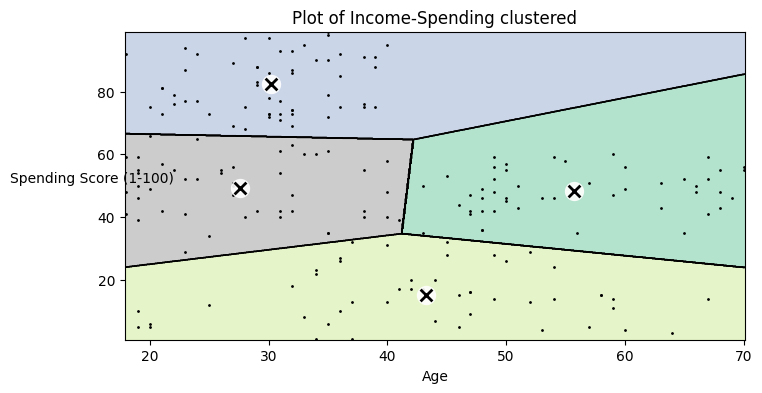

In [40]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.title('Plot of Income-Spending clustered')
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.show()

#Density and outliers

###Step 9:  Visualize density and possible outliers

Exercises:
1. Perform DBSCAN on the "income-spending" dataset. Suggestion: Try with parameters epsilon=8, min_samples=3 (as done the code below)
2. Display clusters and outliers graphically (as done the code below)
3. Discuss the clusters found with KMeans in the light of the information generated with DBSCAN

In [17]:
X = dataset[["Annual Income (k$)", "Spending Score (1-100)"]].values


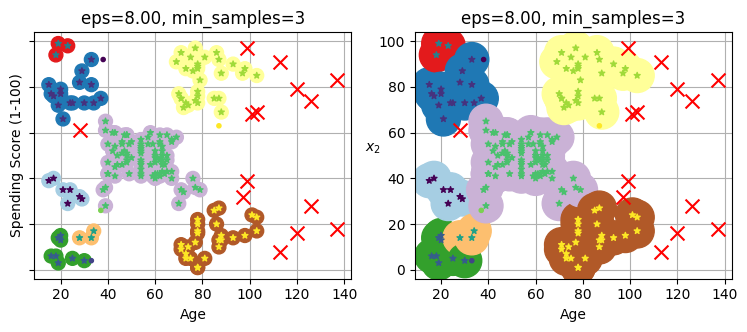

In [18]:
dbscan = DBSCAN(eps=8,min_samples=3)
dbscan.fit(X)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plt.ylabel('Spending Score (1-100)')
plot_dbscan(dbscan, X, size=100, show_ylabels=False)
plt.xlabel('Age')


plt.subplot(122)

plt.ylabel('Spending Score (1-100)')
plot_dbscan(dbscan, X, size=600)
plt.xlabel('Age')

plt.show()

### Step 10: Visualize density and possible outliers (repeated)

Exercises:
1.   Repeat Step 9, where you perform DBSCAN on the "age-spending score" dataset.